In [ ]:
# https://moondol-ai.tistory.com/241
# https://github.com/aeddung/ML-DL/blob/main/koBert_multiclassification.py

!pip install transformers==3

     |████████████████████████████████| 757kB 10.3MB/s 
     |████████████████████████████████| 1.2MB 27.9MB/s 
     |████████████████████████████████| 901kB 36.6MB/s 
     |████████████████████████████████| 3.0MB 35.9MB/s 


In [ ]:
!pip install mxnet
!pip install gluonnlp pandas tqdm
!pip install sentencepiece
!pip install torch

     |████████████████████████████████| 46.9MB 64kB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
     |████████████████████████████████| 348kB 15.1MB/s 
  Created wheel for gluonnlp: filename=gluonnlp-0.10.0-cp37-cp37m-linux_x86_64.whl size=595684 sha256=93ce2f1450a707eff43073a75a3dc50df54fe2500b924b8167ec4d5ae72d52e0
  Stored in directory: /root/.cache/pip/wheels/37/65/52/63032864a0f31a08b9a88569f803b5bafac8abd207fd7f7534
Successfully built gluonnlp


In [ ]:
!pip install git+https://git@github.com/SKTBrain/KoBERT.git@master

  Cloning https://****@github.com/SKTBrain/KoBERT.git (to revision master) to /tmp/pip-req-build-56xwehvx
  Running command git clone -q 'https://****@github.com/SKTBrain/KoBERT.git' /tmp/pip-req-build-56xwehvx
  Created wheel for kobert: filename=kobert-0.1.2-cp37-none-any.whl size=12718 sha256=42cea8de7f48b254611ce08f2a6f3db44f193aaa236502c36cfc9ccda6dff73d
  Stored in directory: /tmp/pip-ephem-wheel-cache-1jautnks/wheels/a2/b0/41/435ee4e918f91918be41529283c5ff86cd010f02e7525aecf3
Successfully built kobert


In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
import numpy as np
from tqdm import tqdm, tqdm_notebook

from kobert.utils import get_tokenizer
from kobert.pytorch_kobert import get_pytorch_kobert_model

from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup

In [ ]:
from nltk import word_tokenize
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import font_manager, rc
import re
!pip install konlpy
from konlpy.tag import Komoran
from pprint import pprint

     |████████████████████████████████| 19.4MB 153kB/s 
     |████████████████████████████████| 92kB 8.9MB/s 
     |████████████████████████████████| 450kB 32.4MB/s 
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
df=pd.read_excel('/content/drive/MyDrive/크롤링데이터2/두타스테리드_1005_네이버카페_추가.xlsx')
df

,title,views,date,content,likes,reply,Effectiveness
0,정수리 탈모에 피니스테리드 두타스테리드중 어느걸써야하나요,174,2021.03.21,정수리 탈모에 피니스테리드 두타스테리드중 어느걸써야하나요유전성도 있는것같습니다글 작...,0,특정부위에 특화된 약품은 없어요..두 성분 다 남성유전형탈모에 적용되니 둘 중 하나...,-7
1,아보다트(두타스테리드)와 프로페시아(피나스테리드) 같이 복용해도 되나요,108,2021.03.23,제곧내 아보다트(두타스테리드)와 프로페시아(피나스테리드) 같이 복용해도 되나요글 작...,0,번갈아복용하는건 봤어요같이 한알씩 얘기하시는건 아니죠?|||||한번에요|||||굳이...,2
2,자신이 탈모때문에 피나스테리드 먹으면 되는지 두타스테리드 먹으면 되는지 아는방법이...,190,2021.03.22,유전성 정수리탈모에 피니스테리드 두타스테리드중 어느걸써야하나요글 작성하기 아래의 내...,1,분명한건 피나는 한가지두타는 두가지입니다.그러므로 두타가 좀더 쌔다고 생각드네요 먹...,1
3,자기가 두타스테리드 먹으면 되는지 피니스테리드 먹으면 되는지 아는방법,161,2021.03.21,자기가 피나스테리드 먹으면 되는지 두타스테리드 먹으면 되는지 아는 방법이 있나요 그...,1,없습니다 한가지약을 1년동안 먹어보고 약효과가 안받고 계속 꾸준히탈모가 빠르게 진행...,-8
4,두타스테리드가 전립선암을 유발하나요,341,2021.01.10,글 작성하기 부작용으로 전립선암을 유발할수있다면 이거 굉장히 위험한거 아닌가요그리고...,0,전림선암을 유발하는건 아니고 전립선암 검사시 오류가 난다네요.|||||기형아의 경우...,3
...,...,...,...,...,...,...,...
1000,나의탈모이야기,190,2017.09.17,안녕하세요 이마반입니다힘든 시간 동안 홀로 외로이 싸우셨다면 이제부터 만명의 이마반...,0,NaN,-8
1001,가입인사합니다,117,2017.09.13,안녕하세요 이마반입니다힘든 시간 동안 홀로 외로이 싸우셨다면 이제부터 만명의 이마반...,0,NaN,-5
1002,안녕하세요,11,2017.09.14,안녕하세요 이마반입니다힘든 시간 동안 홀로 외로이 싸우셨다면 이제부터 만명의 이마반...,0,NaN,-2
1003,안녕하세요,36,2017.09.06,안녕하세요 이마반입니다힘든 시간 동안 홀로 외로이 싸우셨다면 이제부터 만명의 이마반...,0,NaN,-4


In [ ]:
def text_cleansing(text):
    list = ['댓글', '신고', '공유', '게시', '글 작성하기', '제휴', 
           '게시글', '더보기', '좋아요', '등록순', '최신순','새로고침', 
           '후기', '이벤트', '모네 상스', '병원', '경기', '등록', '작성', 
           '베스트', '리얼', '상담', '신청', '이야기', '회원', '정보', 
           '탈모 탈모', '회칙', '플러스', '가입', '홍보', '통보', '삭제', 
           '답변', '활동', '정지', '공지', '작성', '말머리', '답변', '설정', 
           '정보', '쪽지', '일정', '선물', '리뷰', '적립', '확인']
    for a in list:
        text = text.replace(a, '')

    return text

In [ ]:
df['content'][0]

'정수리 탈모에 피니스테리드 두타스테리드중 어느걸써야하나요유전성도 있는것같습니다글 작성하기 아래의 내용은 삭제 하지 마세요 탈모모발이식 영상 정보 모발이식 희망심기 탈모모발이식 금칙어 확인 탈모약치료제 토론방 모발이식두피문신 토론방 여성 헤어라인두피문신 토론방 모발이식두피문신 후기 보러가기 여성 헤어라인두피문신 후기 보러가기 모발이식 피해불만족 사례 게시판 강원머리야자라나라님의 게시글 더보기 좋아요 댓글 공유 신고 댓글 등록순 최신순 새로고침 경기그레 특정부위에 특화된 약품은 없어요두 성분 다 남성유전형탈모에 적용되니 둘 중 하나 처방받아 복용하면 됩니다 강원머리야자라나라 얼마나 복용해야 효과나타나나요 그리고 둘중하나 복용했다가 효고없으면요 경기그레 강원머리야자라나라복용 중 효과없다고 생각되면 의사와 상담하여 다른거 처방받아보셔도 되겠지만 약효를 판단하는 기준이 모발이 어느 정도 채워지는지 여부라면 적어도 일년정도는 복용해보셔야겠죠 부산으아헤 차이없음 본인이 기대하는 효과가 뭔지 부터 정확히해야함탈모약의 최대 효과는 탈모지연입니다 탈모 정지도 아님 부산으아헤 효과는 최소 년 이상 서울두식이야 ) 보통 피나계열에서 시작했다가 두타계열로 넘어갑니다) 최소 개월 개월 정도 복용 후 효과를 살피고 (빠지는 정도 모발에 힘이 생기는 느낌 확인 뒤) 비용 고려하여 장복하시는 경우가 많습니다 강원머리야자라나라 피나를 장복하나요 서울두식이야 강원머리야자라나라보통 피나 년 정도 장복하고 있습니다 (개인적인 견해입니다)아무래도 두타가 쎈 약물이다보니피나 년 장복 후 개월 (두타계열) 부작용 확인 큰 문제 없을 시 년 두타계열또 다시 피나로 장복하고 왔다갔다 합니당 강원머리야자라나라 서울두식이야왜 왔다갔다 하나요 서울두식이야 강원머리야자라나라효과가 떨어졌다고 생각했을 때 물론 한 가지 약물 장복해도 되지만 가지 선택지가 있는 입장에서 한 가지만 고집할 이유는 없지요 특히나 부작용도 없다면 두타로 넘어가지 않을 이유는 없다고 봅니다맨날 두부 김치찌개만 먹다가 돼지고기가 첨가된 두부

In [ ]:
i = 0
for w in df['content']:
  df['content'][i] = text_cleansing(w)
  i +=1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
df['content'][0]

'정수리 탈모에 피니스테리드 두타스테리드중 어느걸써야하나요유전성도 있는것같습니다 아래의 내용은  하지 마세요 탈모모발이식 영상  모발이식 희망심기 탈모모발이식 금칙어  탈모약치료제 토론방 모발이식두피문신 토론방 여성 헤어라인두피문신 토론방 모발이식두피문신  보러가기 여성 헤어라인두피문신  보러가기 모발이식 피해불만족 사례 판 강원머리야자라나라님의 글          그레 특정부위에 특화된 약품은 없어요두 성분 다 남성유전형탈모에 적용되니 둘 중 하나 처방받아 복용하면 됩니다 강원머리야자라나라 얼마나 복용해야 효과나타나나요 그리고 둘중하나 복용했다가 효고없으면요 그레 강원머리야자라나라복용 중 효과없다고 생각되면 의사와 하여 다른거 처방받아보셔도 되겠지만 약효를 판단하는 기준이 모발이 어느 정도 채워지는지 여부라면 적어도 일년정도는 복용해보셔야겠죠 부산으아헤 차이없음 본인이 기대하는 효과가 뭔지 부터 정확히해야함탈모약의 최대 효과는 탈모지연입니다 탈모 도 아님 부산으아헤 효과는 최소 년 이상 서울두식이야 ) 보통 피나계열에서 시작했다가 두타계열로 넘어갑니다) 최소 개월 개월 정도 복용 후 효과를 살피고 (빠지는 정도 모발에 힘이 생기는 느낌  뒤) 비용 고려하여 장복하시는 경우가 많습니다 강원머리야자라나라 피나를 장복하나요 서울두식이야 강원머리야자라나라보통 피나 년 정도 장복하고 있습니다 (개인적인 견해입니다)아무래도 두타가 쎈 약물이다보니피나 년 장복 후 개월 (두타계열) 부작용  큰 문제 없을 시 년 두타계열또 다시 피나로 장복하고 왔다갔다 합니당 강원머리야자라나라 서울두식이야왜 왔다갔다 하나요 서울두식이야 강원머리야자라나라효과가 떨어졌다고 생각했을 때 물론 한 가지 약물 장복해도 되지만 가지 선택지가 있는 입장에서 한 가지만 고집할 이유는 없지요 특히나 부작용도 없다면 두타로 넘어가지 않을 이유는 없다고 봅니다맨날 두부 김치찌개만 먹다가 돼지고기가 첨가된 두부 김치찌개 먹어보니 크게 문제없으니 이거 먹다가 질려서 처음 먹었던 것으로 갈아타는주 일 (월 토) 

In [ ]:
import numpy as np
y = df['Effectiveness']
y = np.array(y, dtype=object)


In [ ]:
y2 = []
for i in y:
  if i < 0:
    y2.append(0) # -
  elif i == 0:
    y2.append(1) # 0
  else:
    y2.append(2) # +

In [ ]:
y2 = np.array(y2, dtype=object)
len(y2)

1005

In [ ]:
y2 = y2.astype(float)

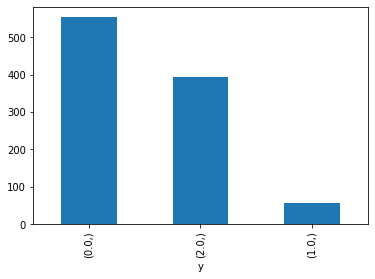

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

y3 = pd.DataFrame(data=y2, columns=['y'])
y3.value_counts().plot(kind='bar')

In [ ]:
y2[100]

0.0

In [ ]:
new_data = pd.concat([df['content'],y3], axis=1)
new_data

,content,y
0,정수리 탈모에 피니스테리드 두타스테리드중 어느걸써야하나요유전성도 있는것같습니다 아래...,0.0
1,제곧내 아보다트(두타스테리드)와 프로페시아(피나스테리드) 같이 복용해도 되나요 아래...,2.0
2,유전성 정수리탈모에 피니스테리드 두타스테리드중 어느걸써야하나요 아래의 내용은 하지...,2.0
3,자기가 피나스테리드 먹으면 되는지 두타스테리드 먹으면 되는지 아는 방법이 있나요 그...,0.0
4,부작용으로 전립선암을 유발할수있다면 이거 굉장히 위험한거 아닌가요그리고 두타스테리...,2.0
...,...,...
1000,안녕하세요 이마반입니다힘든 시간 동안 홀로 외로이 싸우셨다면 이제부터 만명의 이마반...,0.0
1001,안녕하세요 이마반입니다힘든 시간 동안 홀로 외로이 싸우셨다면 이제부터 만명의 이마반...,0.0
1002,안녕하세요 이마반입니다힘든 시간 동안 홀로 외로이 싸우셨다면 이제부터 만명의 이마반...,0.0
1003,안녕하세요 이마반입니다힘든 시간 동안 홀로 외로이 싸우셨다면 이제부터 만명의 이마반...,0.0


In [ ]:
##GPU 사용 시
device = torch.device("cuda:0")

In [ ]:
bertmodel, vocab = get_pytorch_kobert_model()

[██████████████████████████████████████████████████]
[██████████████████████████████████████████████████]


In [ ]:
# 기본 Bert tokenizer 사용
from gluonnlp.data import SentencepieceTokenizer

tokenizer = get_tokenizer()
#tok  = SentencepieceTokenizer(tokenizer, vocab)
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, max_len,
                 pad, pair):
        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len, pad=pad, pair=pair) 
        self.sentences = [transform(i[[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))

using cached model


In [ ]:
# Setting parameters
max_len = 64 # 해당 길이를 초과하는 단어에 대해선 bert가 학습하지 않음
batch_size = 64
warmup_ratio = 0.1
num_epochs = 100
max_grad_norm = 1
log_interval = 200
learning_rate = 5e-5

In [ ]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(new_data, test_size=0.3,  random_state=0)

In [ ]:
data_train = BERTDataset(train.values, 0, 1, tok, max_len, True, False)
data_test = BERTDataset(test.values, 0, 1, tok, max_len, True, False)

In [ ]:
# pytorch용 DataLoader 사용
train_dataloader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, num_workers=5)
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, num_workers=5)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes = 3, # softmax 사용 <- binary일 경우는 2
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
                 
        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)
    
    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        
        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)

In [ ]:
model = BERTClassifier(bertmodel, dr_rate=0.5).to(device)

In [ ]:
# Prepare optimizer and schedule (linear warmup and decay)
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]


In [ ]:
# 옵티마이저 선언
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss() # softmax용 Loss Function 정하기 <- binary classification도 해당 loss function 사용 가능

t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

In [ ]:
# 학습 평가 지표인 accuracy 계산 -> 얼마나 타겟값을 많이 맞추었는가
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

In [ ]:
# https://quokkas.tistory.com/entry/pytorch%EC%97%90%EC%84%9C-EarlyStop-%EC%9D%B4%EC%9A%A9%ED%95%98%EA%B8%B0
class EarlyStopping:
    """주어진 patience 이후로 validation loss가 개선되지 않으면 학습을 조기 중지"""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt'):
        """
        Args:
            patience (int): validation loss가 개선된 후 기다리는 기간
                            Default: 7
            verbose (bool): True일 경우 각 validation loss의 개선 사항 메세지 출력
                            Default: False
            delta (float): 개선되었다고 인정되는 monitered quantity의 최소 변화
                            Default: 0
            path (str): checkpoint저장 경로
                            Default: 'checkpoint.pt'
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''validation loss가 감소하면 모델을 저장한다.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [ ]:
patience = 3
early_stopping = EarlyStopping(patience = patience, verbose = True)
criterion = nn.CrossEntropyLoss()

In [ ]:
# 모델 학습 시작
# 모델이 학습되는 동안 trainning loss를 track
train_losses = []

for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    model.train()
    y_train_list = []
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        _, y_train_tags = torch.max(out, dim = 1)
        y_train_list.append(y_train_tags.cpu().numpy())
        loss = criterion(out, label)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm) # gradient clipping
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(out, label)
        train_losses.append(loss.item())
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
    y_train_list = [a.squeeze().tolist() for a in y_train_list]
    train_loss = np.average(train_losses)
    early_stopping(train_loss, model)

    if early_stopping.early_stop:
      print("Early stopping")
      break
    model.load_state_dict(torch.load('checkpoint.pt'))
    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch 1 batch id 1 loss 1.1424845457077026 train acc 0.28125

Validation loss decreased (inf --> 1.105103).  Saving model ...
epoch 1 train acc 0.3371663059163059


epoch 2 batch id 1 loss 1.0327181816101074 train acc 0.5

Validation loss decreased (1.105103 --> 1.050696).  Saving model ...
epoch 2 train acc 0.4908008658008658


epoch 3 batch id 1 loss 0.9455932378768921 train acc 0.53125

Validation loss decreased (1.050696 --> 0.998076).  Saving model ...
epoch 3 train acc 0.5519705988455988


epoch 4 batch id 1 loss 0.8818182349205017 train acc 0.46875

Validation loss decreased (0.998076 --> 0.956826).  Saving model ...
epoch 4 train acc 0.5519029581529581


epoch 5 batch id 1 loss 0.8142833113670349 train acc 0.625

Validation loss decreased (0.956826 --> 0.923400).  Saving model ...
epoch 5 train acc 0.6060155122655122


epoch 6 batch id 1 loss 0.8005456924438477 train acc 0.515625

Validation loss decreased (0.923400 --> 0.897087).  Saving model ...
epoch 6 train acc 0.621708152958153


epoch 7 batch id 1 loss 0.8090801239013672 train acc 0.59375

Validation loss decreased (0.897087 --> 0.869254).  Saving model ...
epoch 7 train acc 0.7042748917748918


epoch 8 batch id 1 loss 0.7309170961380005 train acc 0.6875

Validation loss decreased (0.869254 --> 0.842350).  Saving model ...
epoch 8 train acc 0.7454680735930737


epoch 9 batch id 1 loss 0.7007874250411987 train acc 0.703125

Validation loss decreased (0.842350 --> 0.828185).  Saving model ...
epoch 9 train acc 0.7040268759018758


epoch 10 batch id 1 loss 0.7567949295043945 train acc 0.6875

Validation loss decreased (0.828185 --> 0.798793).  Saving model ...
epoch 10 train acc 0.8294101731601732


epoch 11 batch id 1 loss 0.578128457069397 train acc 0.8125

Validation loss decreased (0.798793 --> 0.767616).  Saving model ...
epoch 11 train acc 0.86489898989899


epoch 12 batch id 1 loss 0.6838155388832092 train acc 0.765625

Validation loss decreased (0.767616 --> 0.745931).  Saving model ...
epoch 12 train acc 0.8307178932178932


epoch 13 batch id 1 loss 0.525116503238678 train acc 0.859375

Validation loss decreased (0.745931 --> 0.729317).  Saving model ...
epoch 13 train acc 0.8135822510822511


epoch 14 batch id 1 loss 0.5027860999107361 train acc 0.859375

Validation loss decreased (0.729317 --> 0.708060).  Saving model ...
epoch 14 train acc 0.8592171717171717


epoch 15 batch id 1 loss 0.36590713262557983 train acc 0.890625

Validation loss decreased (0.708060 --> 0.682641).  Saving model ...
epoch 15 train acc 0.9004329004329005


epoch 16 batch id 1 loss 0.40578126907348633 train acc 0.875

Validation loss decreased (0.682641 --> 0.662931).  Saving model ...
epoch 16 train acc 0.8904897186147186


epoch 17 batch id 1 loss 0.4998312294483185 train acc 0.828125

Validation loss decreased (0.662931 --> 0.649286).  Saving model ...
epoch 17 train acc 0.8563988095238095


epoch 18 batch id 1 loss 0.8116214275360107 train acc 0.765625

Validation loss decreased (0.649286 --> 0.648845).  Saving model ...
epoch 18 train acc 0.7839781746031746


epoch 19 batch id 1 loss 0.39389047026634216 train acc 0.859375

Validation loss decreased (0.648845 --> 0.640664).  Saving model ...
epoch 19 train acc 0.8251262626262627


epoch 20 batch id 1 loss 0.354285329580307 train acc 0.921875

Validation loss decreased (0.640664 --> 0.625888).  Saving model ...
epoch 20 train acc 0.9018759018759019


epoch 21 batch id 1 loss 0.30220651626586914 train acc 0.921875

Validation loss decreased (0.625888 --> 0.607178).  Saving model ...
epoch 21 train acc 0.9331259018759019


epoch 22 batch id 1 loss 0.28309425711631775 train acc 0.921875

Validation loss decreased (0.607178 --> 0.590436).  Saving model ...
epoch 22 train acc 0.9331484487734488


epoch 23 batch id 1 loss 0.3282671570777893 train acc 0.921875

Validation loss decreased (0.590436 --> 0.575307).  Saving model ...
epoch 23 train acc 0.9274440836940837


epoch 24 batch id 1 loss 0.2682303786277771 train acc 0.921875

Validation loss decreased (0.575307 --> 0.560406).  Saving model ...
epoch 24 train acc 0.9317279942279942


epoch 25 batch id 1 loss 0.2529563307762146 train acc 0.921875

Validation loss decreased (0.560406 --> 0.546524).  Saving model ...
epoch 25 train acc 0.9317054473304474


epoch 26 batch id 1 loss 0.24491466581821442 train acc 0.9375

Validation loss decreased (0.546524 --> 0.533726).  Saving model ...
epoch 26 train acc 0.938830266955267


epoch 27 batch id 1 loss 0.17752963304519653 train acc 0.953125

Validation loss decreased (0.533726 --> 0.521191).  Saving model ...
epoch 27 train acc 0.9445120851370852


epoch 28 batch id 1 loss 0.2351103276014328 train acc 0.9375

Validation loss decreased (0.521191 --> 0.509441).  Saving model ...
epoch 28 train acc 0.9402056277056278


epoch 29 batch id 1 loss 0.18249139189720154 train acc 0.953125

Validation loss decreased (0.509441 --> 0.498932).  Saving model ...
epoch 29 train acc 0.9430690836940837


epoch 30 batch id 1 loss 0.18256963789463043 train acc 0.953125

Validation loss decreased (0.498932 --> 0.488846).  Saving model ...
epoch 30 train acc 0.9430690836940837


epoch 31 batch id 1 loss 0.1708918809890747 train acc 0.9375

Validation loss decreased (0.488846 --> 0.478866).  Saving model ...
epoch 31 train acc 0.9488185425685426


epoch 32 batch id 1 loss 0.19499757885932922 train acc 0.953125

Validation loss decreased (0.478866 --> 0.469353).  Saving model ...
epoch 32 train acc 0.9473529942279942


epoch 33 batch id 1 loss 0.1536031812429428 train acc 0.953125

Validation loss decreased (0.469353 --> 0.460387).  Saving model ...
epoch 33 train acc 0.9473529942279942


epoch 34 batch id 1 loss 0.1861676722764969 train acc 0.9375

Validation loss decreased (0.460387 --> 0.451965).  Saving model ...
epoch 34 train acc 0.9459325396825397


epoch 35 batch id 1 loss 0.17234401404857635 train acc 0.953125

Validation loss decreased (0.451965 --> 0.444029).  Saving model ...
epoch 35 train acc 0.9444895382395383


epoch 36 batch id 1 loss 0.1724877506494522 train acc 0.953125

Validation loss decreased (0.444029 --> 0.436296).  Saving model ...
epoch 36 train acc 0.9487734487734488


epoch 37 batch id 1 loss 0.18990318477153778 train acc 0.9375

Validation loss decreased (0.436296 --> 0.429033).  Saving model ...
epoch 37 train acc 0.9473304473304474


epoch 38 batch id 1 loss 0.17059843242168427 train acc 0.953125

Validation loss decreased (0.429033 --> 0.422399).  Saving model ...
epoch 38 train acc 0.9502164502164502


epoch 39 batch id 1 loss 0.17852503061294556 train acc 0.953125

Validation loss decreased (0.422399 --> 0.415853).  Saving model ...
epoch 39 train acc 0.9487734487734488


epoch 40 batch id 1 loss 0.1652308702468872 train acc 0.953125

Validation loss decreased (0.415853 --> 0.409551).  Saving model ...
epoch 40 train acc 0.9473304473304474


epoch 41 batch id 1 loss 0.1768806129693985 train acc 0.953125

Validation loss decreased (0.409551 --> 0.403582).  Saving model ...
epoch 41 train acc 0.9444669913419914


epoch 42 batch id 1 loss 0.18948955833911896 train acc 0.953125

Validation loss decreased (0.403582 --> 0.397876).  Saving model ...
epoch 42 train acc 0.9459325396825397


epoch 43 batch id 1 loss 0.16457684338092804 train acc 0.953125

Validation loss decreased (0.397876 --> 0.392392).  Saving model ...
epoch 43 train acc 0.9487734487734488


epoch 44 batch id 1 loss 0.18603529036045074 train acc 0.953125

Validation loss decreased (0.392392 --> 0.387214).  Saving model ...
epoch 44 train acc 0.9473079004329005


epoch 45 batch id 1 loss 0.18226632475852966 train acc 0.9375

Validation loss decreased (0.387214 --> 0.382225).  Saving model ...
epoch 45 train acc 0.9487509018759019


epoch 46 batch id 1 loss 0.17601175606250763 train acc 0.953125

Validation loss decreased (0.382225 --> 0.378109).  Saving model ...
epoch 46 train acc 0.9430690836940837


epoch 47 batch id 1 loss 0.17018604278564453 train acc 0.953125

Validation loss decreased (0.378109 --> 0.373583).  Saving model ...
epoch 47 train acc 0.9487509018759019


epoch 48 batch id 1 loss 0.17796912789344788 train acc 0.953125

Validation loss decreased (0.373583 --> 0.369229).  Saving model ...
epoch 48 train acc 0.9459099927849928


epoch 49 batch id 1 loss 0.1805802881717682 train acc 0.953125

Validation loss decreased (0.369229 --> 0.364983).  Saving model ...
epoch 49 train acc 0.9473529942279942


epoch 50 batch id 1 loss 0.19023223221302032 train acc 0.953125

Validation loss decreased (0.364983 --> 0.361213).  Saving model ...
epoch 50 train acc 0.9501713564213564


epoch 51 batch id 1 loss 0.17412854731082916 train acc 0.953125

Validation loss decreased (0.361213 --> 0.357347).  Saving model ...
epoch 51 train acc 0.9501713564213564


epoch 52 batch id 1 loss 0.1757698804140091 train acc 0.953125

Validation loss decreased (0.357347 --> 0.353619).  Saving model ...
epoch 52 train acc 0.9473079004329005


epoch 53 batch id 1 loss 0.17011919617652893 train acc 0.953125

Validation loss decreased (0.353619 --> 0.349978).  Saving model ...
epoch 53 train acc 0.9487509018759019


epoch 54 batch id 1 loss 0.17516611516475677 train acc 0.953125

Validation loss decreased (0.349978 --> 0.346577).  Saving model ...
epoch 54 train acc 0.9473304473304474


epoch 55 batch id 1 loss 0.17510724067687988 train acc 0.953125

Validation loss decreased (0.346577 --> 0.343239).  Saving model ...
epoch 55 train acc 0.9487734487734488


epoch 56 batch id 1 loss 0.17755256593227386 train acc 0.953125

Validation loss decreased (0.343239 --> 0.339997).  Saving model ...
epoch 56 train acc 0.9487283549783551


epoch 57 batch id 1 loss 0.18793310225009918 train acc 0.953125

Validation loss decreased (0.339997 --> 0.336813).  Saving model ...
epoch 57 train acc 0.9530122655122656


epoch 58 batch id 1 loss 0.18744048476219177 train acc 0.9375

Validation loss decreased (0.336813 --> 0.333754).  Saving model ...
epoch 58 train acc 0.9487734487734488


epoch 59 batch id 1 loss 0.19284307956695557 train acc 0.9375

Validation loss decreased (0.333754 --> 0.330813).  Saving model ...
epoch 59 train acc 0.9473304473304474


epoch 60 batch id 1 loss 0.18774211406707764 train acc 0.953125

Validation loss decreased (0.330813 --> 0.327889).  Saving model ...
epoch 60 train acc 0.9473079004329005


epoch 61 batch id 1 loss 0.18161095678806305 train acc 0.9375

Validation loss decreased (0.327889 --> 0.325077).  Saving model ...
epoch 61 train acc 0.9473304473304474


epoch 62 batch id 1 loss 0.16508588194847107 train acc 0.953125

Validation loss decreased (0.325077 --> 0.322356).  Saving model ...
epoch 62 train acc 0.9501939033189033


epoch 63 batch id 1 loss 0.17818766832351685 train acc 0.953125

Validation loss decreased (0.322356 --> 0.319769).  Saving model ...
epoch 63 train acc 0.9530348124098125


epoch 64 batch id 1 loss 0.1869233101606369 train acc 0.9375

Validation loss decreased (0.319769 --> 0.317229).  Saving model ...
epoch 64 train acc 0.9487509018759019


epoch 65 batch id 1 loss 0.1683512032032013 train acc 0.9375

Validation loss decreased (0.317229 --> 0.314728).  Saving model ...
epoch 65 train acc 0.9487283549783551


epoch 66 batch id 1 loss 0.183391734957695 train acc 0.953125

Validation loss decreased (0.314728 --> 0.312394).  Saving model ...
epoch 66 train acc 0.9487283549783551


epoch 67 batch id 1 loss 0.17533783614635468 train acc 0.953125

Validation loss decreased (0.312394 --> 0.310131).  Saving model ...
epoch 67 train acc 0.9487509018759019


epoch 68 batch id 1 loss 0.194477379322052 train acc 0.9375

Validation loss decreased (0.310131 --> 0.307884).  Saving model ...
epoch 68 train acc 0.9516143578643579


epoch 69 batch id 1 loss 0.16839879751205444 train acc 0.953125

Validation loss decreased (0.307884 --> 0.305710).  Saving model ...
epoch 69 train acc 0.9458874458874459


epoch 70 batch id 1 loss 0.17188358306884766 train acc 0.9375

Validation loss decreased (0.305710 --> 0.303540).  Saving model ...
epoch 70 train acc 0.9516369047619048


epoch 71 batch id 1 loss 0.1700597107410431 train acc 0.953125

Validation loss decreased (0.303540 --> 0.301459).  Saving model ...
epoch 71 train acc 0.954455266955267


epoch 72 batch id 1 loss 0.16376422345638275 train acc 0.953125

Validation loss decreased (0.301459 --> 0.299434).  Saving model ...
epoch 72 train acc 0.9487509018759019


epoch 73 batch id 1 loss 0.16922809183597565 train acc 0.953125

Validation loss decreased (0.299434 --> 0.297478).  Saving model ...
epoch 73 train acc 0.9516143578643579


epoch 74 batch id 1 loss 0.18063728511333466 train acc 0.9375

Validation loss decreased (0.297478 --> 0.295525).  Saving model ...
epoch 74 train acc 0.9487509018759019


epoch 75 batch id 1 loss 0.18301528692245483 train acc 0.9375

Validation loss decreased (0.295525 --> 0.293658).  Saving model ...
epoch 75 train acc 0.9458874458874459


epoch 76 batch id 1 loss 0.1888204663991928 train acc 0.9375

Validation loss decreased (0.293658 --> 0.291839).  Saving model ...
epoch 76 train acc 0.9501488095238095


epoch 77 batch id 1 loss 0.18121595680713654 train acc 0.953125

Validation loss decreased (0.291839 --> 0.290095).  Saving model ...
epoch 77 train acc 0.9501939033189033


epoch 78 batch id 1 loss 0.18501287698745728 train acc 0.953125

Validation loss decreased (0.290095 --> 0.288377).  Saving model ...
epoch 78 train acc 0.9487283549783551


epoch 79 batch id 1 loss 0.1613185703754425 train acc 0.953125

Validation loss decreased (0.288377 --> 0.286728).  Saving model ...
epoch 79 train acc 0.9487283549783551


epoch 80 batch id 1 loss 0.1707647740840912 train acc 0.953125

Validation loss decreased (0.286728 --> 0.285087).  Saving model ...
epoch 80 train acc 0.9501713564213564


epoch 81 batch id 1 loss 0.18171992897987366 train acc 0.9375

Validation loss decreased (0.285087 --> 0.283506).  Saving model ...
epoch 81 train acc 0.9487734487734488


epoch 82 batch id 1 loss 0.1818530559539795 train acc 0.953125

Validation loss decreased (0.283506 --> 0.281955).  Saving model ...
epoch 82 train acc 0.9516143578643579


epoch 83 batch id 1 loss 0.16946496069431305 train acc 0.953125

Validation loss decreased (0.281955 --> 0.280434).  Saving model ...
epoch 83 train acc 0.9530348124098125


epoch 84 batch id 1 loss 0.1656779795885086 train acc 0.953125

Validation loss decreased (0.280434 --> 0.278933).  Saving model ...
epoch 84 train acc 0.9544778138528138


epoch 85 batch id 1 loss 0.18849126994609833 train acc 0.953125

Validation loss decreased (0.278933 --> 0.277485).  Saving model ...
epoch 85 train acc 0.9544778138528138


epoch 86 batch id 1 loss 0.1765376478433609 train acc 0.953125

Validation loss decreased (0.277485 --> 0.276052).  Saving model ...
epoch 86 train acc 0.9515692640692641


epoch 87 batch id 1 loss 0.1801658719778061 train acc 0.953125

Validation loss decreased (0.276052 --> 0.274673).  Saving model ...
epoch 87 train acc 0.9502164502164502


epoch 88 batch id 1 loss 0.18522457778453827 train acc 0.953125

Validation loss decreased (0.274673 --> 0.273316).  Saving model ...
epoch 88 train acc 0.9530348124098125


epoch 89 batch id 1 loss 0.1730050891637802 train acc 0.953125

Validation loss decreased (0.273316 --> 0.271922).  Saving model ...
epoch 89 train acc 0.951591810966811


epoch 90 batch id 1 loss 0.17117710411548615 train acc 0.953125

Validation loss decreased (0.271922 --> 0.270609).  Saving model ...
epoch 90 train acc 0.9473304473304474


epoch 91 batch id 1 loss 0.172144815325737 train acc 0.9375

Validation loss decreased (0.270609 --> 0.269345).  Saving model ...
epoch 91 train acc 0.9487734487734488


epoch 92 batch id 1 loss 0.17723645269870758 train acc 0.9375

Validation loss decreased (0.269345 --> 0.268119).  Saving model ...
epoch 92 train acc 0.951591810966811


epoch 93 batch id 1 loss 0.17490506172180176 train acc 0.9375

Validation loss decreased (0.268119 --> 0.266857).  Saving model ...
epoch 93 train acc 0.9515692640692641


epoch 94 batch id 1 loss 0.17278935015201569 train acc 0.953125

Validation loss decreased (0.266857 --> 0.265632).  Saving model ...
epoch 94 train acc 0.9544327200577201


epoch 95 batch id 1 loss 0.17816905677318573 train acc 0.9375

Validation loss decreased (0.265632 --> 0.264456).  Saving model ...
epoch 95 train acc 0.9444895382395383


epoch 96 batch id 1 loss 0.17697541415691376 train acc 0.9375

Validation loss decreased (0.264456 --> 0.263337).  Saving model ...
epoch 96 train acc 0.954455266955267


epoch 97 batch id 1 loss 0.1795857846736908 train acc 0.9375

Validation loss decreased (0.263337 --> 0.262200).  Saving model ...
epoch 97 train acc 0.9516143578643579


epoch 98 batch id 1 loss 0.1862630993127823 train acc 0.9375

Validation loss decreased (0.262200 --> 0.261100).  Saving model ...
epoch 98 train acc 0.951591810966811


epoch 99 batch id 1 loss 0.1740037053823471 train acc 0.9375

Validation loss decreased (0.261100 --> 0.260087).  Saving model ...
epoch 99 train acc 0.9501713564213564


epoch 100 batch id 1 loss 0.17652569711208344 train acc 0.9375

Validation loss decreased (0.260087 --> 0.259007).  Saving model ...
epoch 100 train acc 0.9501713564213564


In [ ]:
y_train_list2 = []
for i in y_train_list:
  for j in i:
    y_train_list2.append(j)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(train['y'], y_train_list2))

              precision    recall  f1-score   support

         0.0       0.93      0.99      0.96       393
         1.0       0.96      0.68      0.79        40
         2.0       0.98      0.93      0.96       270

    accuracy                           0.95       703
   macro avg       0.96      0.87      0.90       703
weighted avg       0.95      0.95      0.95       703



In [ ]:
print(out[0])

tensor([-2.8036, -2.3325,  5.2178], device='cuda:0', grad_fn=<SelectBackward>)


In [ ]:
# test 모델
# https://towardsdatascience.com/pytorch-tabular-multiclass-classification-9f8211a123ab
test_acc = 0.0
y_pred_list = []
for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):
  token_ids = token_ids.long().to(device)
  segment_ids = segment_ids.long().to(device)
  valid_length= valid_length
  label = label.long().to(device)
  test_out = model(token_ids, valid_length, segment_ids)
  _, y_pred_tags = torch.max(test_out, dim = 1)
  y_pred_list.append(y_pred_tags.cpu().numpy())
  test_acc += calc_accuracy(test_out, label)
print("epoch {} test acc {}".format(e+1, test_acc / (batch_id+1)))
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



epoch 100 test acc 0.6366847826086957


In [ ]:
y_pred_list2 = []
for i in y_pred_list:
  for j in i:
    y_pred_list2.append(j)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(test['y'], y_pred_list2))

              precision    recall  f1-score   support

         0.0       0.65      0.77      0.70       161
         1.0       0.33      0.12      0.17        17
         2.0       0.63      0.53      0.58       124

    accuracy                           0.64       302
   macro avg       0.54      0.47      0.49       302
weighted avg       0.62      0.64      0.62       302



In [ ]:
print(test_out[0])

tensor([ 2.0496, -1.1330, -0.4924], device='cuda:0', grad_fn=<SelectBackward>)


In [ ]:
# 테스트 문장 예측

test_sentence = input("테스트할 텍스트: ")
test_sentence = text_cleansing(test_sentence)
test_label = int(input("실제 감성 척도(0-부정, 1-중립, 2-긍정): ")) 

테스트할 텍스트: 맥주효모


NameError: ignored

In [ ]:
df=pd.read_excel('/content/drive/MyDrive/크롤링데이터2/두타스테리드_17_네이버블로그_추가.xlsx')
test_sentence = df['content'][0]
test_label = df['Effectiveness'][0]
test_sentence = text_cleansing(test_sentence)
if test_label < 0:
  test_label = 0 # -
elif test_label == 0:
  test_label = 1 # 0
else:
   test_label = 2 # +

In [ ]:
unseen_test = pd.DataFrame([[test_sentence, test_label]], columns = [['content', 'y']])
unseen_values = unseen_test.values
test_set = BERTDataset(unseen_values, 0, 1, tok, max_len, True, False)
test_input = torch.utils.data.DataLoader(test_set, batch_size=1, num_workers=5)

for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_input)):
  token_ids = token_ids.long().to(device)
  segment_ids = segment_ids.long().to(device)
  valid_length= valid_length
  final_out = model(token_ids, valid_length, segment_ids)
  final_out2 = final_out.cpu().detach().numpy()
  print(final_out2)
  _, y_pred_tags = torch.max(final_out, dim = 1)
  yhat = y_pred_tags.cpu().numpy()
  print()
  if yhat == 0:
    print("부정이 ", final_out2[0][0], "으로 가장 높으므로 부작용이 나타날 가능성이 높다.")
  elif yhat == 1:
    print("중립이 ", final_out2[0][1], "으로 가장 높으므로 아무런 변화가 없을 가능성이 높다")
  else:
    print("긍정이 ", final_out2[0][2], "으로 가장 높으므로 효과가 나타날 가능성이 높다.")
if (yhat == test_label):
  print("실제 감성 척도 예측에 성공했습니다.")
else:
  print("실제 감성 척도 예측에 실패했습니다.")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


[[ 5.161839  -2.3736193 -2.9353356]]

부정이  5.161839 으로 가장 높으므로 부작용이 나타날 가능성이 높다.

실제 감성 척도 예측에 성공했습니다.


In [ ]:
# 메모리 부족 에러 시 (CUDA out of memory error)
import torch,gc
gc.collect()
torch.cuda.empty_cache()

'\nfeatures = []\nfor x in train_dataloader:\n    x = torch.tensor(x, device=device, dtype=torch.float32)\n    z = model(x)\n    features.append(z.tolist())\n  '

In [ ]:
komoran_userdic = Komoran(userdic='/content/drive/MyDrive/크롤링데이터2/komoran_userdic_탈모약.txt')

In [ ]:
tokens2 = []
for pos in komoran_userdic.pos(test_sentence):
  tokens2.append(pos)
len(tokens2)

1478

In [ ]:
word2=[]
for pos in tokens2:
  if pos[1][:2]=='NN' and len(pos[0])>1:
    word2.append(pos[0])
len(word2)

353

In [ ]:
docs = []
docs.append(' '.join(word2))
docs

['얼마 어버이 모두 코로나 때문 당일 여행 상황 때문 외식 개월 제품 아빠 엄마 어버이날 아빠 유전 내력 인해 오랫동안 머리카락 아빠 오랫동안 고민 이심 유전 요인 유인 해답 관리 속도 해서 엄마 아빠 효과 해주시 저도 영양 제나 샴푸 원리 효과 머리 때문 초면 사람 위축 아빠 모습 이상 아빠 여기저기 효녀 아빠 눈물 모아 전국 각지 아빠 아버님 메인 성분 두타스테리드 성분 머리 원리 호르몬 자연 변화 인해 남성 호르몬 모발 성장 필요 단백질 합성 방해 모발 성분 남성 호르몬 변환 성분 머리카락 최소 원리 변화 성분 두타스테리드 피나스테리드 타스 테리 성분 상품 다트 피나스테리드 성분 상품 가지 성분 상품 차이점 성 호르몬 성분 환원 효소 환원 효소 유형 유형 유형 가지 간단 말하자면 피나스테리드 유형 억제 두타스테리드 유형 유형 모두 억제 때문 두타스테리드 효력 피나스테리드 부작용 발생 다트 정식 승인 피나스테리드 결과 때문 부작용 원리 카피 시중 판매 구매 발생 상품 이유 카피 가격 차이 얼마 카피 에그 나마 우리나라 계속 허가 불법 두타스테리드 다트 결과 정도 유사 상품 개월 이상 복용 실제 구매자 구글 이상 악화 현상 유지 비교 다트 섭취 피로감 성욕 저하 부작용 호소 상당수 부분 아빠 결과 예전 제가 구매 반년 정도 피곤 가지 문제점 승인 허가 기본 증상 원리 그럼에도 불구하고 복용 기본 영양 보충 해서 부작용 조금 부작용 자유로 운수 임신 준비 이신 의약품 대신 두피 혈액 순환 건강 두피 마사지 운동 안전 평생 복합 비오 영양제 대체 방법 아빠 경우 샴푸 셀프 두피 마사지 병행 제가 사드 복합 비오 영양제 복용 사드 영양제 모나 쿠팡 네이버 만개 상당수 긍정 비오 흡수 우려 판토텐산 아미노산 아연 데이 가지 성분 포함 사실 처음 두타스테리드 개월 정도 결과 지라 처음 래미 잔소리 시작 효과 주변 칭찬 시작 시니 지금 제가 잔소리 아빠 아빠 효과 방법 정리 아래 두피 마사지 복합 비오 영양제 건강 관리 두피 마사지 기본 영양 섭취 두피 복합 비오 영

In [ ]:
#  https://its-blog.tistory.com/45

def eojeol(text, n=2):
    ngram = list()
    tokens = text.split()
    for i in range(len(tokens)-(n-1)):
        ngram.append(" ".join(tokens[i:i+n]))
    return ngram

In [ ]:
word3 = [word for doc in docs for word in eojeol(doc)]
pprint(word3)

['얼마 어버이',
 '어버이 모두',
 '모두 코로나',
 '코로나 때문',
 '때문 당일',
 '당일 여행',
 '여행 상황',
 '상황 때문',
 '때문 외식',
 '외식 개월',
 '개월 제품',
 '제품 아빠',
 '아빠 엄마',
 '엄마 어버이날',
 '어버이날 아빠',
 '아빠 유전',
 '유전 내력',
 '내력 인해',
 '인해 오랫동안',
 '오랫동안 머리카락',
 '머리카락 아빠',
 '아빠 오랫동안',
 '오랫동안 고민',
 '고민 이심',
 '이심 유전',
 '유전 요인',
 '요인 유인',
 '유인 해답',
 '해답 관리',
 '관리 속도',
 '속도 해서',
 '해서 엄마',
 '엄마 아빠',
 '아빠 효과',
 '효과 해주시',
 '해주시 저도',
 '저도 영양',
 '영양 제나',
 '제나 샴푸',
 '샴푸 원리',
 '원리 효과',
 '효과 머리',
 '머리 때문',
 '때문 초면',
 '초면 사람',
 '사람 위축',
 '위축 아빠',
 '아빠 모습',
 '모습 이상',
 '이상 아빠',
 '아빠 여기저기',
 '여기저기 효녀',
 '효녀 아빠',
 '아빠 눈물',
 '눈물 모아',
 '모아 전국',
 '전국 각지',
 '각지 아빠',
 '아빠 아버님',
 '아버님 메인',
 '메인 성분',
 '성분 두타스테리드',
 '두타스테리드 성분',
 '성분 머리',
 '머리 원리',
 '원리 호르몬',
 '호르몬 자연',
 '자연 변화',
 '변화 인해',
 '인해 남성',
 '남성 호르몬',
 '호르몬 모발',
 '모발 성장',
 '성장 필요',
 '필요 단백질',
 '단백질 합성',
 '합성 방해',
 '방해 모발',
 '모발 성분',
 '성분 남성',
 '남성 호르몬',
 '호르몬 변환',
 '변환 성분',
 '성분 머리카락',
 '머리카락 최소',
 '최소 원리',
 '원리 변화',
 '변화 성분',
 '성분 두타스테리드',
 '두타스테리드 피나스테리드',
 '피나스테리드 타스',
 '타스 테리',
 '테리 성분',
 '성분 상

In [ ]:
from collections import Counter
counter = Counter(word3)
#pprint(counter)

In [ ]:
import matplotlib.font_manager as fm
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
#path = '/usr/share/fonts/truetype/nanum/NanumGothicLight.ttf'
font_fname = fm.FontProperties(fname=font_path, size=10).get_name()
wordcloud = WordCloud(
    font_path=font_path,
    width = 800,
    height = 800,
    #family = font_fname
)

In [ ]:
#matplotlib.font_manager._rebuild()
#plt.rc('font', family='NanumBarunGothic') 
wordcloud = wordcloud.generate_from_frequencies(counter)

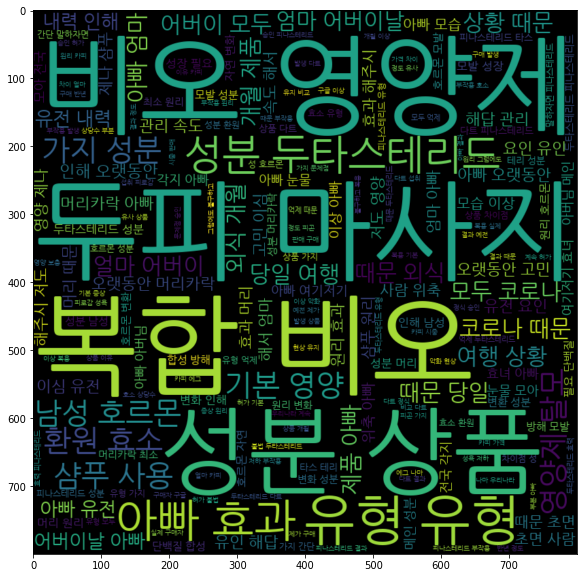

In [ ]:
%matplotlib inline

fig = plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.show()
#fig.savefig('두타스테리드-korean(2-gram).png')

In [ ]:
def showGraph(wordInfo):
    font_manager.get_fontconfig_fonts()
    font_location = "/usr/share/fonts/truetype/nanum/NanumGothic.ttf"
    font_name = font_manager.FontProperties(fname=font_location).get_name()
    font_name2 = font_manager.FontProperties(fname=font_location)
    
    #plt.rc('font', family=font_name)
    
    plt.xlabel('주요 단어')
    plt.ylabel('빈도수')
    plt.grid(True) #그리드로 그림
    
    # wordInfo: 메인에서 만들어짐, 값(x)하고 키, 키가 단어, 벨류가 빈도수
    Sorted_Dict_Values = sorted(wordInfo.values(), reverse=True)
    Sorted_Dict_Keys = sorted(wordInfo, key=wordInfo.get, reverse=True)
    
    # 막대 그래프 그리는 방법
    plt.bar(range(len(wordInfo)), Sorted_Dict_Values, align='center')
    plt.xticks(range(len(wordInfo)), list(Sorted_Dict_Keys), rotation='70')
    plt.rc('font', family=font_name) 
    matplotlib.rc('font', family=font_name)
    plt.rcParams["font.family"] = "NanumGothic" 
    plt.rc('axes', unicode_minus=False)
    font_manager._rebuild()

    plt.show()

두피 마사지 : 4
복합 비오 : 4
비오 영양제 : 4
성분 상품 : 3
유형 유형 : 3
아빠 효과 : 2
성분 두타스테리드 : 2
남성 호르몬 : 2
가지 성분 : 2
환원 효소 : 2
기본 영양 : 2
샴푸 사용 : 2
영양제 탈모 : 2
얼마 어버이 : 1
어버이 모두 : 1
모두 코로나 : 1
코로나 때문 : 1
때문 당일 : 1
당일 여행 : 1
여행 상황 : 1


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 46160 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54588 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47560 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49324 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51648 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48373 missing from current font.
  font.set_

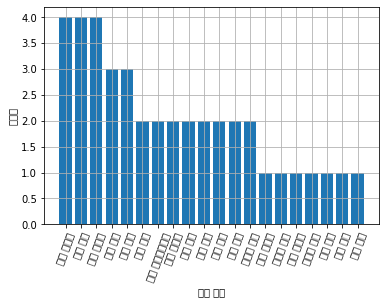

In [ ]:
def main():
    
    wordInfo1 = dict()
    # 최대 20개
    for tags, counts in counter.most_common(20):
        if (len(str(tags)) > 1):
            wordInfo1[tags] = counts
            print ("%s : %d" % (tags, counts))
    showGraph(wordInfo1)
    
if __name__ == "__main__":
    main()

In [ ]:
import json

class KnuSL():
  def data_list2(wordname):
    with open('/content/drive/MyDrive/KnuSentiLex-master/data/SentiWord_info.json', encoding='utf-8-sig', mode='r') as f:
      data = json.load(f)
      #result = ['None','None']	
    p = 0	
    for i in range(0, len(data)):
      if data[i]['word'] == wordname or data[i]['word_root'] == wordname:
        p = int(data[i]['polarity'])
      else:
        p = 999
    return p

In [ ]:
ksl = KnuSL
p = []
w = []
for word in word2:
  k  = ksl.data_list2(word)
  if k != 999:
    p.append(k)
    w.append(word)
print(len(p))
w

0


[]

In [ ]:
counter1 = Counter(w)

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 46160 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54588 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47560 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49324 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51648 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48373 missing from current font.
  font.set_

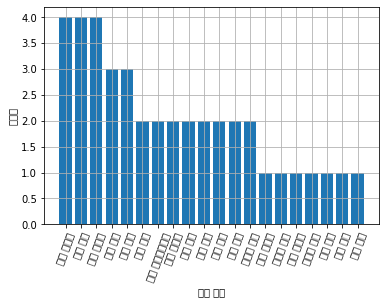

In [ ]:
def main():
    
    wordInfo3 = dict()
    # 최대 20개
    for tags, counts in counter.most_common(20):
        if (len(str(tags)) > 1):
            wordInfo3[tags] = counts
    showGraph(wordInfo3)
    
if __name__ == "__main__":
    main()

In [ ]:
count = {}   #동시출현 빈도가 저장될 dict
tokens3 = [i[0] for i in tokens2 if len(i[0])>1]
for i, a in enumerate(tokens3):
  for b in tokens3[i+1:]:
    if a>b: 
      count[b, a] = count.get((b, a),0) + 1  
    else :
      count[a, b] = count.get((a, b),0) + 1     

In [ ]:
dfdf=pd.DataFrame.from_dict(count, orient='index')
dfdf

,0
"(어버이, 얼마)",2
"(는데요, 얼마)",12
"(모두, 얼마)",8
"(보내, 얼마)",4
"(나요, 얼마)",2
...,...
"(자세, 탈모)",2
"(검색, 발견)",1
"(검색, 탈모)",2
"(발견, 탈모)",2


In [ ]:
list1=[]
for i in range(len(dfdf)):
    list1.append([dfdf.index[i][0],dfdf.index[i][1],dfdf[0][i]])

dfdf2=pd.DataFrame(list1, columns=["term1","term2","freq"])

dfdf3=dfdf2.sort_values(by=['freq'],ascending=False)

df3_pos=dfdf3.reset_index(drop=True)
dfdf3

,term1,term2,freq
7258,성분,아빠,130
6842,아빠,으로,91
7259,두타스테리드,아빠,91
7418,아빠,영양제,91
7174,다고,아빠,91
...,...,...,...
34561,보니,생기,1
34560,생기,을지,1
34559,생기,이번,1
34558,생기,인사,1


In [ ]:
import networkx as nx
import operator

G_pos=nx.Graph() # 그래프 만들기

# 네트워크 만들기, 시각화 안된 네트워크
for i in range((len(np.where(df3_pos['freq']>10)[0]))):
    G_pos.add_edge(df3_pos['term1'][i], df3_pos['term2'][i], weight=int(df3_pos['freq'][i]))

# 각 값 계산, 키워드, 벨류 형태
dgr = nx.degree_centrality(G_pos)
btw = nx.betweenness_centrality(G_pos)
cls = nx.closeness_centrality(G_pos)
egv = nx.eigenvector_centrality(G_pos) # 영향력이 있는 단어를 많이 아는 단어

In [ ]:
sorted_dgr = sorted(dgr.items(), key=operator.itemgetter(1), reverse=True)
# 아이템: 각 단어, 해 당 값
print("** degree **")
for x in range(10):
    print(sorted_dgr[x])

** degree **
('아빠', 1.0056980056980058)
('성분', 0.35042735042735046)
('으로', 0.35042735042735046)
('두타스테리드', 0.35042735042735046)
('영양제', 0.35042735042735046)
('다고', 0.35042735042735046)
('드리', 0.35042735042735046)
('많이', 0.35042735042735046)
('어요', 0.35042735042735046)
('상품', 0.35042735042735046)


In [ ]:
sorted_btw = sorted(btw.items(), key=operator.itemgetter(1), reverse=True)
print("** betweenness **")
for x in range(10):
    print(sorted_btw[x])

** betweenness **
('아빠', 0.8864085605752271)
('성분', 0.0046014787681454335)
('으로', 0.0046014787681454335)
('두타스테리드', 0.0046014787681454335)
('영양제', 0.0046014787681454335)
('다고', 0.0046014787681454335)
('드리', 0.0046014787681454335)
('많이', 0.0046014787681454335)
('어요', 0.0046014787681454335)
('상품', 0.0046014787681454335)


In [ ]:
sorted_cls = sorted(cls.items(), key=operator.itemgetter(1), reverse=True)
print("** closeness **")
for x in range(10):
    print(sorted_cls[x])

** closeness **
('아빠', 1.0)
('성분', 0.6041308089500861)
('으로', 0.6041308089500861)
('두타스테리드', 0.6041308089500861)
('영양제', 0.6041308089500861)
('다고', 0.6041308089500861)
('드리', 0.6041308089500861)
('많이', 0.6041308089500861)
('어요', 0.6041308089500861)
('상품', 0.6041308089500861)


In [ ]:
sorted_egv = sorted(egv.items(), key=operator.itemgetter(1), reverse=True)
print("** eigenvector **")
for x in range(10):
    print(sorted_egv[x])

** eigenvector **
('아빠', 0.16721312685308673)
('성분', 0.15721989610511433)
('으로', 0.15721989610511433)
('두타스테리드', 0.15721989610511433)
('영양제', 0.15721989610511433)
('다고', 0.15721989610511433)
('드리', 0.15721989610511433)
('많이', 0.15721989610511433)
('어요', 0.15721989610511433)
('상품', 0.15721989610511433)


In [ ]:
G = nx.Graph()

# 노드 넣기
for i in range(len(sorted_cls)):
    G.add_node(sorted_cls[i][0], nodesize=sorted_dgr[i][1])

In [ ]:
# 엣지 넣기
for i in range((len(np.where(df3_pos['freq']>10)[0]))):
    G.add_weighted_edges_from([(df3_pos['term1'][i], df3_pos['term2'][i],int(df3_pos['freq'][i]))])

In [ ]:
!apt-get update -qq
!apt-get install fonts-nanum* -qq

Selecting previously unselected package fonts-nanum-eco.
(Reading database ... 160790 files and directories currently installed.)
Preparing to unpack .../fonts-nanum-eco_1.000-6_all.deb ...
Unpacking fonts-nanum-eco (1.000-6) ...
Selecting previously unselected package fonts-nanum-extra.
Preparing to unpack .../fonts-nanum-extra_20170925-1_all.deb ...
Unpacking fonts-nanum-extra (20170925-1) ...
Selecting previously unselected package fonts-nanum-coding.
Preparing to unpack .../fonts-nanum-coding_2.5-1_all.deb ...
Unpacking fonts-nanum-coding (2.5-1) ...
Setting up fonts-nanum-extra (20170925-1) ...
Setting up fonts-nanum-coding (2.5-1) ...
Setting up fonts-nanum-eco (1.000-6) ...
Processing triggers for fontconfig (2.12.6-0ubuntu2) ...


In [ ]:
!apt install fonts-nanum

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 39 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 2s (5,554 kB/s)
Selecting previously unselected package fonts-nanum.
(Reading database ... 160772 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20170925-1_all.deb ...
Unpacking fonts-nanum (20170925-1) ...
Setting up fonts-nanum (20170925-1) ...
Processing triggers for fontconfig (2.12.6-0ubuntu2) ...


In [ ]:
import matplotlib
matplotlib.font_manager._rebuild()

In [ ]:
from matplotlib import font_manager, rc
for font in font_manager.fontManager.ttflist:
    if 'Nanum' in font.name:
        print(font.name, font.fname)

NanumGothic /usr/share/fonts/truetype/nanum/NanumGothic.ttf
NanumGothic /usr/share/fonts/truetype/nanum/NanumGothicBold.ttf
NanumBarunGothic /usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf
NanumSquare /usr/share/fonts/truetype/nanum/NanumSquareB.ttf
NanumSquare /usr/share/fonts/truetype/nanum/NanumSquareR.ttf
NanumSquareRound /usr/share/fonts/truetype/nanum/NanumSquareRoundR.ttf
NanumMyeongjo /usr/share/fonts/truetype/nanum/NanumMyeongjo.ttf
NanumMyeongjo /usr/share/fonts/truetype/nanum/NanumMyeongjoBold.ttf
NanumSquareRound /usr/share/fonts/truetype/nanum/NanumSquareRoundB.ttf
NanumBarunGothic /usr/share/fonts/truetype/nanum/NanumBarunGothicBold.ttf


In [ ]:
import matplotlib as mpl
mpl.rcParams['axes.unicode_minus'] = False

In [ ]:
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

sys_font=fm.findSystemFonts()
print(f"sys_font number: {len(sys_font)}")

nanum_font = [f for f in sys_font if 'Nanum' in f]
print(f"nanum_font number: {len(nanum_font)}")



sys_font number: 17
nanum_font number: 0


In [ ]:
fm._rebuild()

In [ ]:
sizes = [G.nodes[node]['nodesize']*500 for node in G]
font_manager.get_fontconfig_fonts()
path = '/usr/share/fonts/truetype/nanum/NanumGothicLight.ttf'
font_fname = fm.FontProperties(fname=path, size=10).get_name()

# width 표현x, 엣지 겹치면 진하게x
options = {
    'edge_color': '#FFDEA2',
    'width': 1,
    'with_labels': True,
    'font_weight': 'regular',
    'font_family':font_fname, 
}
plt.rc('font', family=font_fname) 
matplotlib.rc('font', family=font_fname)
plt.rcParams["font.family"] = "NanumGothic" 
plt.rc('axes', unicode_minus=False)
font_manager._rebuild()

#fm._rebuild()
#font_fname= '/content/drive/MyDrive/크롤링데이터2/MALGUN.TTF'
#fontprop = fm.FontProperties(fname=font_fname, size=18).get_name()

In [ ]:
!apt -qq -y install fonts-nanum > /dev/null

import matplotlib.font_manager as fm

fontpath = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'

font = fm.FontProperties(fname=fontpath, size=9)

fm._rebuild()

# 그래프에 retina display 적용

%config InlineBackend.figure_format = 'retina'

# Colab 의 한글 폰트 설정

plt.rc('font', family='NanumBarunGothic') 

In [ ]:
nx.draw(G, node_size=sizes, pos=nx.spring_layout(G, k=3.5, iterations=50), **options)
ax = plt.gca()
ax.collections[0].set_edgecolor("#555555") 
plt.rc('font', family=font_fname)
plt.rc('axes', unicode_minus=False)
plt.show()

NameError: ignored